In [1]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install torchinfo
from torchinfo import summary

### LeNet-5

In [2]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2), ## Convolutional layer
          nn.Sigmoid(), ## Non-linearity
          nn.AvgPool2d(kernel_size=2, stride=2),  ## Average pooling layer
          nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  ## Convolutional layer
          nn.Sigmoid(), ## Non-linearity
          nn.AvgPool2d(kernel_size=2, stride=2),  ## Average Pooling
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), ## convert to one dimensional vector features
        nn.Linear(in_features=16*5*5, out_features=120), ## Dense layer
        nn.Sigmoid(), ## Non-linearity
        nn.Linear(in_features=120, out_features=84),
        nn.Sigmoid(),
        nn.Linear(in_features=84, out_features=10),
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.classifier(x)
    return x

#### Model Summary

In [3]:
## Model summary
summary(model=LeNet5(), input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature_extractor)         [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Sigmoid (1)                       [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Sigmoid (4)                       [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

#### MNIST dataloader

In [4]:
## Define the transformations to apply to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

## Download the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

## Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

## Create data loaders for training, validation and testing sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

#### Training Loop

In [5]:
## Initialize the model, loss function, optimizer, and other hyperparameters
net = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 10

## Training loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

train_loss, validation_loss = [], []
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ## get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        ## zero the parameter gradients
        optimizer.zero_grad()
        ## forward + backward + optimize
        outputs = net(inputs) ## Forward pass
        loss = criterion(outputs, labels) ## Loss
        loss.backward() ## backward pass
        optimizer.step() ## update weights
        running_loss += loss.item()

    ## Validation loop
    running_val_loss = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()

    print(f'Epoch: {epoch+1}, Training Loss: {running_loss/len(trainloader)}, Validation Loss: {running_val_loss/len(valloader)}')
    train_loss.append(running_loss/len(trainloader))
    validation_loss.append(running_val_loss/len(valloader))

print('Finished Training')

 10%|█         | 1/10 [00:37<05:33, 37.10s/it]

Epoch: 1, Training Loss: 1.0880194343328475, Validation Loss: 0.359623567934366


 20%|██        | 2/10 [01:05<04:17, 32.18s/it]

Epoch: 2, Training Loss: 0.2480261560281118, Validation Loss: 0.2077051050406187


 30%|███       | 3/10 [01:34<03:33, 30.52s/it]

Epoch: 3, Training Loss: 0.16120696083952984, Validation Loss: 0.14685641994026113


 40%|████      | 4/10 [02:03<03:00, 30.07s/it]

Epoch: 4, Training Loss: 0.11945307033260663, Validation Loss: 0.12137141898076267


 50%|█████     | 5/10 [02:34<02:31, 30.29s/it]

Epoch: 5, Training Loss: 0.0978959124200046, Validation Loss: 0.10255930628231232


 60%|██████    | 6/10 [03:03<01:59, 29.77s/it]

Epoch: 6, Training Loss: 0.08098419555711249, Validation Loss: 0.08999069897517403


 70%|███████   | 7/10 [03:31<01:28, 29.41s/it]

Epoch: 7, Training Loss: 0.07018288445100188, Validation Loss: 0.08744140732736189


 80%|████████  | 8/10 [04:00<00:58, 29.18s/it]

Epoch: 8, Training Loss: 0.06296005488062899, Validation Loss: 0.0717427817240179


 90%|█████████ | 9/10 [04:29<00:28, 28.99s/it]

Epoch: 9, Training Loss: 0.055348634820431473, Validation Loss: 0.06637471835649117


100%|██████████| 10/10 [04:57<00:00, 29.76s/it]

Epoch: 10, Training Loss: 0.050474292700489365, Validation Loss: 0.07034289817811247
Finished Training


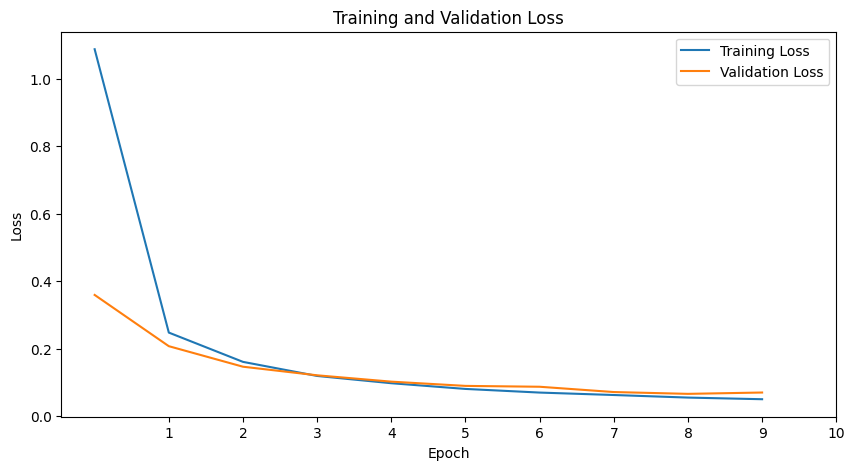

In [6]:
## Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Test the model

In [7]:
correct = 0
total = 0
## we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        ## calculate outputs by running images through the network
        outputs = net(images)
        ## the class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on MNIST test images: {100 * correct / total} %')

Accuracy of the network on MNIST test images: 98.21 %
